In [4]:
import requests
import pandas as pd
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

foursquare_api_key = os.getenv('Foursquare_api_key')

Build a regression model.

Provide model output and an interpretation of the results. 

In [5]:
url = "http://api.citybik.es/v2/networks"
response = requests.get(url)

if response.status_code == 200:
    response_data = response.json()
    networks = response_data.get('networks', [])
    vancouver_network = None
    for network in networks:
        if network['location']['city'].lower() == 'vancouver':
            vancouver_network = network
            break

    if vancouver_network:
        network_id = vancouver_network['id']
        details_url = f"http://api.citybik.es/v2/networks/{network_id}"
        details_response = requests.get(details_url)
        
        if details_response.status_code == 200:
            vancouver_details = details_response.json()
            stations_in_vancouver = vancouver_details.get('network', {}).get('stations', [])
        else:
            print(f"Failed to retrieve details for Vancouver network: {details_response.status_code}")
    else:
        print("Vancouver network not found.")
else:
    print(f"Failed to retrieve data: {response.status_code}")

foursquare_headers = {
    "accept": "application/json",
    "Authorization":  f"{foursquare_api_key}"
}
foursquare_url = "https://api.foursquare.com/v3/places/search"

station_data = []

for station in stations_in_vancouver:
    latitude = station['latitude']
    longitude = station['longitude']
    params = {
        'll': f'{latitude},{longitude}',
        'radius': 1000,
        'categories': '13065,13027'
    }
    response = requests.get(foursquare_url, headers=foursquare_headers, params=params)
    
    if response.status_code == 200:
        data = response.json()
        places = data.get('results', [])
        num_places = len(places)
        station_data.append({
            'Latitude': latitude,
            'Longitude': longitude,
            'Number of Restaurants and Bars': num_places
        })
    else:
        print(f"Failed to retrieve data from Foursquare API: {response.status_code}")

df = pd.DataFrame(station_data)

df['Number of Bike Stations'] = [1] * len(df)

X = df[['Number of Restaurants and Bars']]
X = sm.add_constant(X)
y = df['Number of Bike Stations']

ols_model = sm.OLS(y, X).fit()

print(ols_model.summary())

df['Predicted Number of Bike Stations'] = ols_model.predict(X)

most_suitable_location = df.loc[df['Predicted Number of Bike Stations'].idxmax()]

print("Most Suitable Location:")
print(most_suitable_location)

                               OLS Regression Results                              
Dep. Variable:     Number of Bike Stations   R-squared:                        -inf
Model:                                 OLS   Adj. R-squared:                   -inf
Method:                      Least Squares   F-statistic:                    -254.0
Date:                     Sat, 14 Sep 2024   Prob (F-statistic):               1.00
Time:                             21:15:32   Log-Likelihood:                 8111.5
No. Observations:                      256   AIC:                        -1.622e+04
Df Residuals:                          254   BIC:                        -1.621e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

C:\Users\kasun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


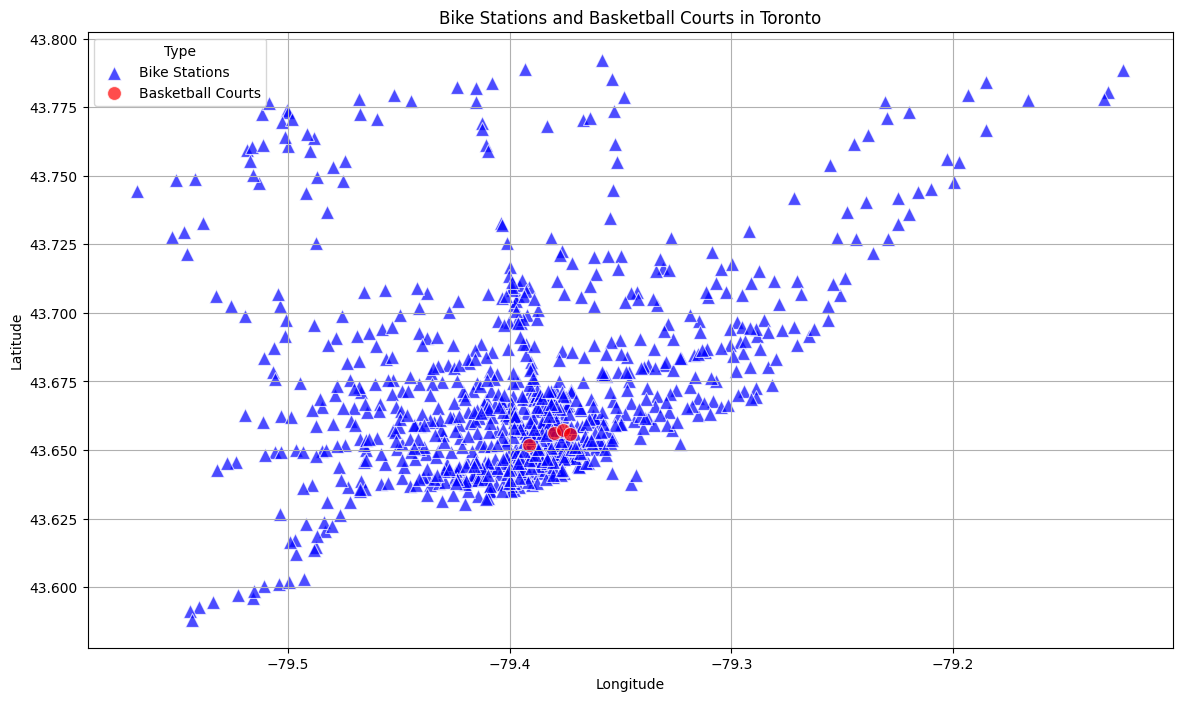

In [7]:
# Fetch Bike Station Data
base_url = "https://api.citybik.es/v2/networks"
network_id = "bixi-toronto"  # Network ID for Toronto
stations_url = f"{base_url}/{network_id}"

response = requests.get(stations_url)
data = response.json()
stations = data['network']['stations']

df_bike_stations = pd.DataFrame(stations)
df_bike_stations = df_bike_stations[['name', 'latitude', 'longitude', 'free_bikes']]
df_bike_stations.columns = ['Station Name', 'Latitude', 'Longitude', 'Number of Bikes']

# Fetch Basketball Court Data
url = "https://api.foursquare.com/v3/places/search"
headers = {
    "Authorization": f"{foursquare_api_key}", 
    "accept": "application/json"
}

params_basketball_courts = {
    'll': '43.653226,-79.3831843',  # Latitude and Longitude for Toronto
    'radius': 1000,  # Radius in meters
    'query': 'basketball court',
    'limit': 10
}
response_basketball_courts = requests.get(url, headers=headers, params=params_basketball_courts)
data_basketball_courts = response_basketball_courts.json()

def extract_venues(data, query):
    venues = data.get('results', [])
    return pd.DataFrame([{
        'Name': venue.get('name'),
        'Latitude': venue.get('geocodes', {}).get('main', {}).get('latitude'),
        'Longitude': venue.get('geocodes', {}).get('main', {}).get('longitude'),
        'Category': venue.get('categories', [{}])[0].get('name'),
        'Search Query': query
    } for venue in venues])

df_basketball_courts = extract_venues(data_basketball_courts, 'Basketball Court')

# Create scatter plots for bike stations and basketball courts
plt.figure(figsize=(14, 8))

# Scatter plot for bike stations (using blue triangles)
sns.scatterplot(data=df_bike_stations, x='Longitude', y='Latitude',
                label='Bike Stations', color='blue', marker='^', s=100, alpha=0.7)

# Scatter plot for basketball courts (using red dots)
sns.scatterplot(data=df_basketball_courts, x='Longitude', y='Latitude',
                label='Basketball Courts', color='red', marker='o', s=100, alpha=0.7)

plt.title('Bike Stations and Basketball Courts in Toronto')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Type')
plt.grid(True)
plt.show()


#Proximity Analysis:Density of Bike Stations vs. Basketball Courts:By plotting both types of locations, you can observe how closely these two types of POIs are situated relative to each other. 
#If bike stations are densely concentrated in certain areas, it may indicate high pedestrian or bike traffic areas which could correlate with the presence of basketball courts



# Stretch

How can you turn the regression model into a classification model?

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import Binarizer

file_path = 'C:/Users/kasun/Desktop/Data Analytics/Project 02/practice test/Joining API Question/citybike_created_df.csv'
df_vancouver_data = pd.read_csv(file_path)

file_path = 'C:/Users/kasun/Desktop/Data Analytics/Project 02/practice test/Joining API Question/foursquare_created_df.csv'
df_dining_and_drinking = pd.read_csv(file_path)

df_vancouver_data['Type'] = 'Bike Station'
df_dining_and_drinking['Type'] = 'Restaurant/Bar'
combined_df = pd.concat([df_vancouver_data, df_dining_and_drinking])



# Prepare features and target variable
combined_df = combined_df.dropna(subset=['Latitude', 'Longitude'])
X = combined_df[['Longitude']]
y = combined_df['Latitude']

bins = [-float('inf'), 49.25, 49.30, float('inf')]
labels = ['Low', 'Medium', 'High']
y_binned = pd.cut(y, bins=bins, labels=labels)

scaler = Binarizer()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binned, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 0  1]
 [ 0 53]]
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         1
      Medium       0.98      1.00      0.99        53

    accuracy                           0.98        54
   macro avg       0.49      0.50      0.50        54
weighted avg       0.96      0.98      0.97        54



C:\Users\kasun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kasun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kasun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati